In [1]:
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

import diffoptics as optics

# Part 1 : hands-on

## Let us create a scene with a sensor, a lens and an atom cloud

In [2]:
f = 35e-3 # Focal length (in meters)
m = .15 # Magnification

In [3]:
image_pof = -f * (1 + m)
object_pof = f * (1 + m) / m

# Sensor
sensor = optics.Sensor(position=(image_pof, 0, 0), resolution=(9600, 9600), 
                       pixel_size=(3.76e-6, 3.76e-6), poisson_noise_mean=2, 
                       quantum_efficiency=0.8)

# Lens
lens = optics.PerfectLens(f=f, m=m, position=torch.tensor([0., 0., 0.]))

# Scene
scene = optics.Scene(sensor)
scene.add_object(lens, is_lens=True)

atom_cloud = optics.AtomCloud(position=torch.tensor([object_pof, 0., 0.]), phi=0.1)

### Visualizing the scene

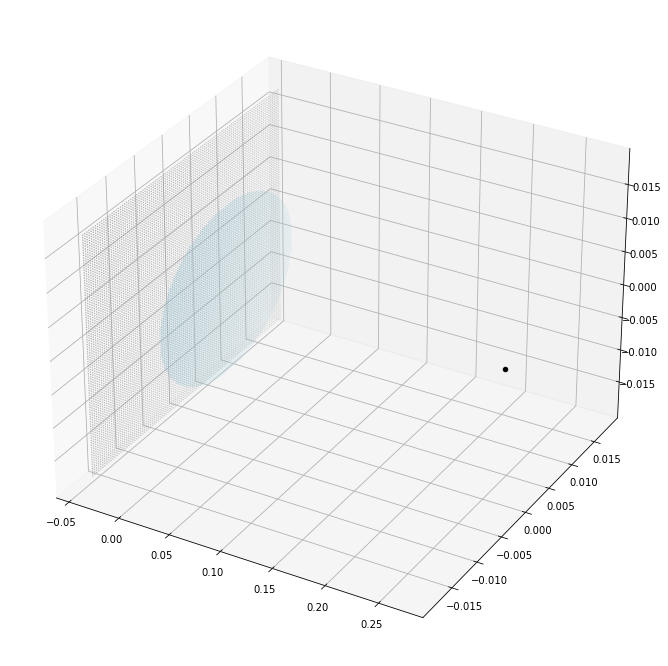

In [4]:
fig = plt.figure(figsize=(12, 12))
ax = fig.gca(projection='3d')
scene.plot(ax)
atom_cloud.plot(ax, c='black')

### Sampling rays in 4pi from the cloud

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

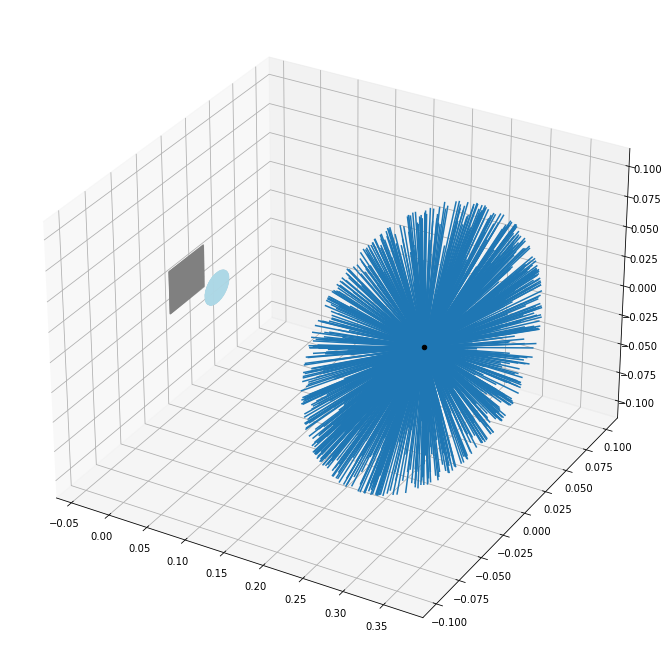

In [6]:
# Sample rays in 4pi
nb_rays = int(1e3)
rays = atom_cloud.sample_rays(nb_rays, device=device)

# Visualization
fig = plt.figure(figsize=(12, 12))
ax = fig.gca(projection='3d')
scene.plot(ax)
atom_cloud.plot(ax, c='black')
rays.plot(ax, torch.zeros(nb_rays) + .1)

### Producing an image

In [8]:
# Sampling rays in 4pi
rays = atom_cloud.sample_rays(int(50e6), device=device)

# Tracking the rays to the sensor
optics.forward_ray_tracing(rays, scene, max_iterations=2, quantum_efficiency=True)

# Cleaning
del rays
torch.cuda.empty_cache()

# Readout
img = scene.sensor.readout(add_poisson_noise=True)

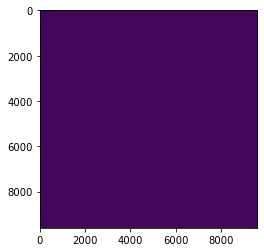

In [9]:
plt.imshow(img.data.numpy()) # Can't see anything, the sensor is too large

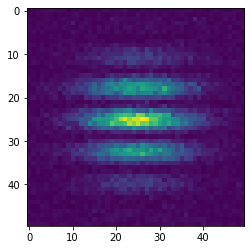

In [10]:
img_center = (img.shape[0] // 2, img.shape[1] // 2)
width = 50
plt.imshow(img[img_center[0] - width // 2 : img_center[0] + width // 2,
               img_center[1] - width // 2 : img_center[1] + width // 2].data.numpy())

### Let us image over 10us (we expect 1B rays) and let us introduce poisson fluctuations

In [9]:
nb_atoms = torch.poisson(torch.tensor([1e6]))
nb_rays = torch.poisson((nb_atoms * 1e3))

print(nb_rays)

tensor([9.9973e+08])


### Ray tracing 1B rays won't fit in memory. Let us process with minibatches (recommended to run on GPU)

In [11]:
with torch.no_grad():
    
    nb_rays_left_to_sample = int(nb_rays)
    batch_size = int(50e6)
    for _ in tqdm(range(int(np.ceil(nb_rays / batch_size)))):
        rays = atom_cloud.sample_rays(min(batch_size, nb_rays_left_to_sample), device=device)
        optics.forward_ray_tracing(rays, scene, max_iterations=1, quantum_efficiency=True)
        nb_rays_left_to_sample -= batch_size

        # Cleaning
        del rays
        torch.cuda.empty_cache()
    
img = scene.sensor.readout(add_poisson_noise=True)

100%|██████████| 20/20 [10:24<00:00, 31.22s/it]


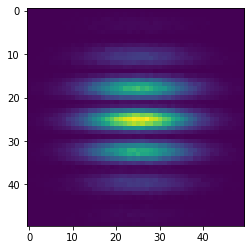

In [12]:
img_center = (img.shape[0] // 2, img.shape[1] // 2)
width = 50
plt.imshow(img[img_center[0] - width // 2 : img_center[0] + width // 2,
               img_center[1] - width // 2 : img_center[1] + width // 2].data.numpy())

# Part 2 : creating helpers

In [13]:
def make_scene(f=0.05, m=0.15, na=1 / 1.4, sensor_resolution=(9600, 9600), sensor_pixel_size=(3.76e-6, 3.76e-6),
               poisson_noise_mean=2, quantum_efficiency=0.8):

    image_pof = -f * (1 + m)
    object_pof = f * (1 + m) / m

    # Sensor
    sensor = optics.Sensor(position=(image_pof, 0, 0), resolution=sensor_resolution, pixel_size=sensor_pixel_size,
                    poisson_noise_mean=poisson_noise_mean, quantum_efficiency=quantum_efficiency)

    # Scene
    scene = optics.Scene(sensor)

    # Lens
    lens = optics.PerfectLens(f=f, m=m, na=na)
    scene.add_object(lens, is_lens=True)
    
    # Atom Cloud
    atom_cloud = optics.AtomCloud(position=torch.tensor([object_pof, 0., 0.]))

    return scene, atom_cloud

In [14]:
def make_image(scene, atom_cloud, phi=0.1, device='cpu', nb_rays=int(1e9), batch_size=int(50e6),
               quantum_efficiency=True, add_poisson_noise=True, show_progress=True):

    with torch.no_grad():

        progress_bar = tqdm if show_progress else lambda x: x
        nb_rays_left_to_sample = nb_rays
        for _ in progress_bar(range(int(np.ceil(nb_rays / batch_size)))):
            rays = atom_cloud.sample_rays(min(batch_size, nb_rays_left_to_sample), device=device)
            optics.forward_ray_tracing(rays, scene, max_iterations=1, quantum_efficiency=quantum_efficiency)
            nb_rays_left_to_sample -= batch_size

        return scene.sensor.readout(add_poisson_noise=add_poisson_noise)

In [15]:
calibration_camera = {'f': 0.025,
                      'm': 0.243,
                      'na': 1 / 1.4,
                      'quantum_efficiency': .75,
                      'poisson_noise_mean': 3,
                      'sensor_resolution': (3088, 3088),
                      'sensor_pixel_size': (2.4e-6, 2.4e-6)}

scene, atom_cloud = make_scene(**calibration_camera)

img = make_image(scene, atom_cloud)

100%|██████████| 20/20 [10:12<00:00, 30.65s/it]


# Part 3 : Analyses

The interface makes it easy to run different analyses
- Grid search over the lens and camera parameters
- Studying the DOF/FOV by varying the atom cloud position
- ...